In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy import stats
import scipy
from ast import literal_eval
from scipy.stats import mannwhitneyu
import numpy as np 
import matplotlib.pyplot as plt 
import pandahouse as ph
import requests
from urllib.parse import urlencode
from scipy.stats import bootstrap

# 1. A/B–тестирование

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

Загрузим файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента

In [2]:
path_to_active_studs = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'

In [3]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
final_url = base_url + urlencode(dict(public_key=path_to_active_studs))
response = requests.get(final_url)
download_url = response.json()['href']
active_studs = pd.read_csv(download_url, ';')

Загрузим файл с информацией об оплатах пользователей в дни проведения эксперимента

In [4]:
path_to_checks = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

In [5]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
final_url = base_url + urlencode(dict(public_key=path_to_checks))
response = requests.get(final_url)
download_url = response.json()['href']
checks = pd.read_csv(download_url, ';')

Загрузим дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

In [6]:
path_to_group_add = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'

In [7]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
final_url = base_url + urlencode(dict(public_key=path_to_group_add))
response = requests.get(final_url)
download_url = response.json()['href']
group_add = pd.read_csv(download_url)

Загрузим файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

In [8]:
path_to_groups = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'

In [9]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
final_url = base_url + urlencode(dict(public_key=path_to_groups))
response = requests.get(final_url)
download_url = response.json()['href']
groups = pd.read_csv(download_url, sep=';')

Сделаем проверку на пропуски в данных — как мы видим, их нет

In [10]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [11]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [12]:
group_add.isna().sum()

id     0
grp    0
dtype: int64

In [13]:
groups.isna().sum()

id     0
grp    0
dtype: int64

Сделаем проверку на дубликаты — их нет

In [14]:
active_studs.duplicated().value_counts()

False    8341
dtype: int64

In [15]:
checks.duplicated().value_counts()

False    541
dtype: int64

In [16]:
groups.duplicated().value_counts()

False    74484
dtype: int64

In [17]:
group_add.duplicated().value_counts()

False    92
dtype: int64

Добавим в таблицу groups значения из таблицы group_add, которые нам дослали через 2 дня после передачи данных. Будем считать, что эти пользователи были включены в эксперимент в одно время с остальными. Но в реальности я бы уточнила это.

Переименуем колонку id в student_id, чтобы затем сделать join

In [18]:
groups_all = pd.concat([groups, group_add], ignore_index=True).rename(columns={'id': 'student_id'})

Оставим только тех пользователей, которые зашли на платформу в дни проведения эксперимента

In [19]:
active_groups = groups_all.merge(active_studs, how = 'inner', on = 'student_id')

Посмотрим сколько наблюдений в каждой из групп

In [20]:
active_groups.value_counts('grp')

grp
B    6803
A    1538
dtype: int64

Добавим в таблицу информацию об оплатах пользователей в дни проведения эксперимента

In [21]:
df = active_groups.merge(checks, on = 'student_id', how = 'left')

Так как в ходе эксперимента мы меняли механику оплаты, нам интересно как это повлияло на количество потраченных покупателями денег, а также в целом на количество покупок.

Выберем метрики:

1. средний чек (средняя стоимость одной покупки)

2. конверсия в покупку 



Обе метрики соответствуют критериям хорошей метрики:

Доступная для понимания — вся команда понимает, что значит эта метрика, так как она незамысловата


Чувствительная — метрика сразу отразит какие-то проблемы в одном или нескольких направлениях


Actionable — метрика несет смысл, и ее динамика или сравнение с другими метриками нам о чём-то говорит и меняет наше поведение


Быстрая — нам не нужно ждать конца месяца, чтобы посчитать эту метрику


Релевантная — относится к нашим целям и тому, что мы хотим понять или узнать

Сначала посмотрим как новый алгоритм повлиял на средний чек

Посчитаем количество потраченных денег каждым покупателем в контрольной и экспериментальной группе и сравним их. Предварительно уберем пользователей, которые не соверщали покупок.

In [22]:
df_control = df.dropna().query("grp == 'A'").groupby('student_id').agg({'rev': 'sum'})

In [23]:
df_test = df.dropna().query("grp == 'B'").groupby('student_id').agg({'rev': 'sum'})

Для начала просто посмотрим на средние чеки в контрольной и экспериментальной группах

In [24]:
df_control.rev.mean()

933.5897435897435

In [25]:
df_test.rev.mean()

1257.8789920382164

Посмотрим на распределения оплат. Чтобы понять, сможем ли мы использовать t-тест, сделаем тесты на нормальность (normaltest) и на гомогенность дисперсий (levene)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4594aafe48>]],
      dtype=object)

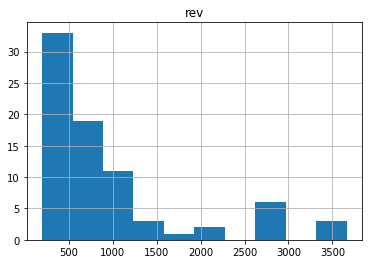

In [26]:
df_control.hist('rev')

In [27]:
scipy.stats.normaltest(df_control.rev)

NormaltestResult(statistic=30.378419638487475, pvalue=2.5316868804220266e-07)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f45949ed470>]],
      dtype=object)

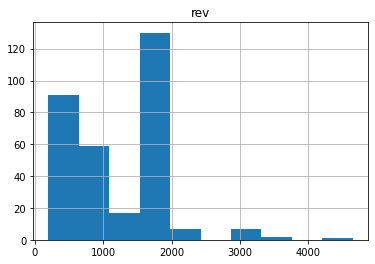

In [28]:
df_test.hist('rev')

In [29]:
scipy.stats.normaltest(df_test.rev)

NormaltestResult(statistic=6.795662714490353, pvalue=0.033445723194625424)

In [30]:
stats.levene(df_control.rev, df_test.rev, center='mean')

LeveneResult(statistic=0.35109219559848354, pvalue=0.5538389015879754)

Вывод: в тесте на нормальность p-value < 0.05, а значит мы отклоняем нулевую гипотезу о том, что распределения нормальные. В тесте на гомогенность дисперсий p-value > 0.05, а значит мы не можем отклонить нулевую гипотезу о том, что дисперсии гомогенны.

Так как распеределения не нормальны, попробуем прологарифмировать значения и посмотрим на распределения

In [31]:
df_control['rev_log'] = np.log(df_control['rev'])

In [32]:
df_test['rev_log'] = np.log(df_test['rev'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4594714128>]],
      dtype=object)

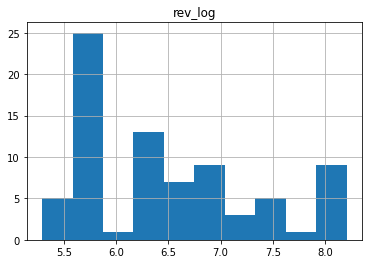

In [33]:
df_control.hist('rev_log')

In [34]:
scipy.stats.normaltest(df_control.rev_log)

NormaltestResult(statistic=7.9915399191892345, pvalue=0.018393278875655582)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f459469f208>]],
      dtype=object)

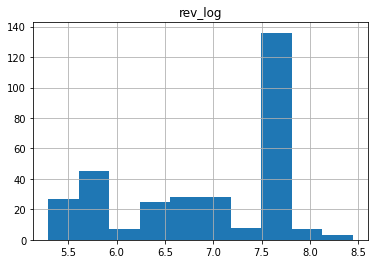

In [35]:
df_test.hist('rev_log')

In [36]:
scipy.stats.normaltest(df_test.rev_log)

NormaltestResult(statistic=85.32513110701674, pvalue=2.9640341038161647e-19)

In [37]:
len(df_test) 

314

In [38]:
len(df_control)

78

Даже после логарифмирования распределения не прошли проверку на нормальность. А также если учесть, что в одной из групп меньше 100 наблюдений, то принимаем решение не использовать t-критерий Стьюдента. Используем метод бутстрапа (bootstrap), позволяющий оценить доверительный интервал для среднего чека в экспериментальной и контрольной группах.

In [39]:
df_control_bootstrap = df_control.rev.to_frame()

In [40]:
bootstrap((df_control_bootstrap, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=array([754.65957399]), high=array([1170.65765509])), standard_error=array([104.11121143]))

In [41]:
df_test_bootstrap = df_test.rev.to_frame()

In [42]:
bootstrap((df_test_bootstrap, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=array([1171.35045157]), high=array([1346.30553557])), standard_error=array([44.74900044]))

Вывод: метод бутстрапа позволяет нам оценить доверительные интервалы для стреднего чека в контрольной и экспериментальной группах. Для экспериментальной группы доверительный интервал 1171 - 1346; для контрольной 758 - 1161. Мы видим, что доверительные интервалы не пересекаются, а значит мы можем сделать вывод о том, что средний чек в экспериментальной группе выше, чем в контрольной.

Теперь посмотрим как новый алгоритм повлиял на конверсию в покупку, то есть на долю пользователей, совершивших покупку

Для начала сделаем дополнительную колонку, в которой определим, совершил ли пользователь покупку. True - была покупка, False - не было покупки

In [43]:
df['bought'] = df['rev'].notna()

Мы хотим посмотреть на состав наших пользователей по группам и количеству покупок. На основе наших данных мы можем построить следующую таблицу:

In [44]:
df2 = df.groupby(['grp', 'bought'], as_index=False).count().pivot_table(columns='bought', index = 'grp', values = 'student_id')

In [45]:
df2

bought,False,True
grp,,
A,1460,78
B,6489,314


Проанализируем таблицу. Пусть мы хотим проверить, зависит ли количество покупок от группы (контрольная или экспериментальня). Наша гипотеза H0: распределение не зависит от группы. Используем хи-квадрат.
На выходе получаем
1. Значение Хи-статистики
2. p-value
3. Количество степеней свободы
4. Ожидаемые значения величин как если бы нулевая гипотеза была верна

In [46]:
chi, p, dof, exp = chi2_contingency(df2)

In [47]:
print('p-value = ' + str(p))

p-value = 0.48625240457231045


Вывод: значение p_value больше 0,05, значит мы не можем отвергнуть нулевую гипотезу. И принимаем вывод, что для контрольной и экспериментальной групп распределение покупок не различается.

Таким образом, по итогам АВ теста мы можем сделать вывод о том, что в экспериментальной группе вырос средний чек, и различия статистически значимы, а значит можем запускать новую механику на всех пользователей.

# 2. SQL# 

2.1 напишем запрос, который даст информацию о количестве очень усердных студентов. NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [48]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [49]:
q = '''
    SELECT COUNT(DISTINCT(st_id)) AS diligent_students
    FROM 
        (SELECT st_id, SUM(correct)
        FROM peas
        GROUP BY st_id
        HAVING SUM(correct)>=20)
    '''
diligent_students = ph.read_clickhouse(query=q, connection=connection_default)
diligent_students

,diligent_students
0,136


2.2 Оптимизация воронки. В одном запросе выгрузим следующую информацию о группах пользователей:

ARPU 


ARPAU 


CR в покупку 


СR активного пользователя в покупку 


CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

In [50]:
q = '''
SELECT round(sum(money_total)/count(distinct st_id)) AS ARPU,
		round(sum(money_total)/count(distinct (CASE WHEN money_total > 0 THEN st_id ELSE Null END))) AS ARPAU,
	   round(count(distinct (CASE WHEN money_total > 0 THEN st_id ELSE Null END)) / count(distinct st_id),2) AS CR,
	   round(count(distinct (CASE WHEN money_total > 0 THEN st_id ELSE Null END)) / count(distinct (CASE WHEN peases > 10 THEN st_id ELSE Null END)),2) AS CR_activ,
	   round(count(distinct (CASE WHEN money_total > 0 THEN st_id ELSE Null END)) / count(distinct (CASE WHEN peases_math >= 2 THEN st_id ELSE Null END)),2) AS CR_activ_math,
		test_grp AS test_grp
FROM
	(
	SELECT 
		st_id AS st_id,
		B.test_grp,
		SUM(correct) AS peases,
		SUM(CASE WHEN subject = 'Math' THEN correct ELSE 0 END) AS peases_math
	FROM peas AS A
	JOIN studs AS B
	ON A.st_id = B.st_id 
	GROUP BY st_id, test_grp
	)AS l
	LEFT JOIN 
	(
	SELECT 
		st_id, 
		SUM(money) AS money_total, 
		SUM(CASE WHEN subject = 'Math' THEN money ELSE 0 END) AS money_math
	FROM final_project_check 
	GROUP BY st_id
	) AS r
	ON l.st_id = r.st_id
GROUP BY test_grp
    '''
all_metrics = ph.read_clickhouse(query=q, connection=connection_default)
all_metrics

,ARPU,ARPAU,CR,CR_activ,CR_activ_math,test_grp
0,8394.0,92333.0,0.09,0.12,0.31,control
1,22832.0,108833.0,0.21,0.31,0.71,pilot


# 3. Python

1. Реализуем функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [56]:
path = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'

In [57]:
def recalculate(path):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=path_to_group_add))
    response = requests.get(final_url)
    download_url = response.json()['href']
    group_add = pd.read_csv(download_url)
    groups_all = pd.concat([groups, group_add], ignore_index=True).rename(columns={'id': 'student_id'})
    active_groups = groups_all.merge(active_studs, how = 'inner', on = 'student_id')
    df = active_groups.merge(checks, on = 'student_id', how = 'left')
    average_check_A = df.dropna().query("grp == 'A'").groupby('student_id').agg({'rev': 'sum'}).rev.mean().round(2)
    average_check_B = df.dropna().query("grp == 'B'").groupby('student_id').agg({'rev': 'sum'}).rev.mean().round(2)
    df['bought'] = df['rev'].notna()
    df2 = df.groupby(['grp', 'bought'], as_index=False).count().pivot_table(columns='bought', index = 'grp', values = 'student_id')
    conv_A = (df2.query("grp=='A'")[True] / df2.query("grp=='A'")[False]).round(3).to_list()[0]
    conv_B = (df2.query("grp=='B'")[True] / df2.query("grp=='B'")[False]).round(3).to_list()[0]
    d = {'average_check': [average_check_A, average_check_B], 'CR': pd.Series([conv_A, conv_B], index=['control', 'expetimental'])}
    metrics = pd.DataFrame(data=d)
    print(metrics)


In [58]:
recalculate(path)

              average_check     CR
control              933.59  0.053
expetimental        1257.88  0.048


2. Реализуем функцию, которая будет строить графики по получаемым метрикам.

In [59]:
def plot(path):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=path_to_group_add))
    response = requests.get(final_url)
    download_url = response.json()['href']
    group_add = pd.read_csv(download_url)
    groups_all = pd.concat([groups, group_add], ignore_index=True).rename(columns={'id': 'student_id'})
    active_groups = groups_all.merge(active_studs, how = 'inner', on = 'student_id')
    df = active_groups.merge(checks, on = 'student_id', how = 'left')
    average_check_A = df.dropna().query("grp == 'A'").groupby('student_id').agg({'rev': 'sum'}).rev.mean().round(2)
    average_check_B = df.dropna().query("grp == 'B'").groupby('student_id').agg({'rev': 'sum'}).rev.mean().round(2)
    df['bought'] = df['rev'].notna()
    df2 = df.groupby(['grp', 'bought'], as_index=False).count().pivot_table(columns='bought', index = 'grp', values = 'student_id')
    conv_A = (df2.query("grp=='A'")[True] / df2.query("grp=='A'")[False]).round(3).to_list()[0]
    conv_B = (df2.query("grp=='B'")[True] / df2.query("grp=='B'")[False]).round(3).to_list()[0]
    d = {'average_check': [average_check_A, average_check_B], 'CR': pd.Series([conv_A, conv_B], index=['control', 'expetimental'])}
    metrics = pd.DataFrame(data=d).reset_index().rename(columns={'index':'group'})
    x = np.array(metrics.group.to_list())
    y = np.array(metrics.CR.to_list())
    plt.subplot(1, 2, 1)
    plt.bar(x,y)
    plt.title("CR")
    x = np.array(metrics.group.to_list())
    y = np.array(metrics.average_check.to_list())
    plt.subplot(1, 2, 2)
    plt.bar(x,y)
    plt.title("Average check")
    plt.show()

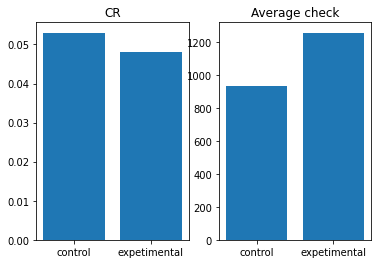

In [60]:
plot(path)